In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [ ]:
# !pip install tf2crf
# !pip install seqeval==1.0.0
# !apt-get install g++ openjdk-8-jdk python-dev python3-dev 
# !pip install JPype1-py3 
# !pip install konlpy 
# !JAVA_HOME="C:\Program Files\Java\jdk-13.0.2"

In [24]:
from tqdm.notebook import tqdm
import numpy as np
import re
from itertools import product
from collections import OrderedDict
from konlpy.tag import Okt
okt = Okt()

# 파라미터로 입력받은 파일에 저장된 단어 리스트를 딕셔너리 형태로 저장
def load_vocab(f_name):
    vocab_file = open(os.path.join(root_dir + 'data', f_name),'r',encoding='utf8')
    print("{} vocab file loading...".format(f_name))

    # default 요소가 저장된 딕셔너리 생성
    symbol2idx, idx2symbol = {"<PAD>":0, "<UNK>":1}, {0:"<PAD>", 1:"<UNK>"}

    # 시작 인덱스 번호 저장
    index = len(symbol2idx)
    for line in vocab_file.readlines():
        symbol = line.strip()
        symbol2idx[symbol] = index
        idx2symbol[index]= symbol
        index+=1

    return symbol2idx, idx2symbol

def load_dict(f_name):
    print("{} dict file loading...".format(f_name))
    with open(os.path.join(root_dir + 'data', f_name),'r',encoding='utf8') as f:
        dictionary = []
        for line in f.readlines():
            line = re.sub("\n", "", line)
            line = line.replace(" ", "")
            dictionary.append(line)
    
    return set(dictionary)

# 입력 데이터를 고정 길이의 벡터로 표현하기 위한 함수
def convert_data2feature(words, symbol2idx, max_length=None):
    # 고정 길이의 0 벡터 생성
    feature = np.zeros(shape=(max_length), dtype=np.int)
    # 입력 문장을 공백 기준으로 split

    for idx, word in enumerate(words[:max_length]):
        if word in symbol2idx.keys():
            feature[idx] = symbol2idx[word]
        else:
            feature[idx] = symbol2idx["<UNK>"]
    return feature

def convert_sent2pos(sent):
    sent = sent.replace(" ","")
    sent = sent.replace("<SP>"," ")

    okt_sent = okt.pos(sent)

    pos_seq = []
    sent_index = 0
    for pos in okt_sent:
        for _ in range(len(pos[0])):
            pos_seq.append(pos[1])
            sent_index += 1
        try:
            if sent[sent_index].isspace():
                pos_seq.append("Space")
                sent_index += 1
        except IndexError:  # 문장의 끝
            pass

    return pos_seq


def get_ngram(word, min=2, max=15):
    ngrams = []

    word = word[:max]  # 단어 하나의 길이가 너무 길 경우, 조합의 수가 너무 많아짐

    for comb in product([0, 1], repeat=len(word)-1):
        split_index = [0]
        for i in range(len(comb)):
            if comb[i] == 1:
                split_index.append(i+1)
        
        split_index.append(None)
        ngram = [word[split_index[i]:split_index[i+1]] for i in range(len(split_index)-1)]
        
        for ng in ngram:
            if min <= len(ng) <= max:
                ngrams.append(ng)
    
    ngrams = list(OrderedDict.fromkeys(ngrams))
    ngrams.sort(key=len)
    return ngrams
    
        
def convert_sent2dict(sent, max_length):
    sent = sent.replace(" ","")
    sent = sent.replace("<SP>"," ")

    original_length = len(sent)

    sent_dict_counted = []
    words = sent.split()

    for word in words:
        loc_count, org_count, per_count = 0, 0, 0
        ngrams = get_ngram(word)

        for ngram in ngrams:
            if ngram in loc_dict:
                loc_count +=1
            if ngram in org_dict:
                org_count +=1
            if ngram in per_dict:
                per_count +=1
        for char in word:
            sent_dict_counted.append([loc_count, org_count, per_count])
        sent_dict_counted.append([0, 0, 0])  # 띄어쓰기

    while len(sent_dict_counted) < max_length:
        sent_dict_counted.append([0, 0, 0])

    return sent_dict_counted[:120]

# 파라미터로 입력받은 파일로부터 tensor객체 생성
def load_data(config, f_name, word2idx, tag2idx, pos2idx):
    file = open(os.path.join(root_dir + 'data', f_name),'r',encoding='utf8')

    # return할 문장/라벨 리스트 생성
    indexing_sentence, indexing_pos, indexing_tags, dict_counts = [], [], [], []

    print("{} file loading...".format(f_name))

    # 실제 데이터는 아래와 같은 형태를 가짐
    # 문장 \t 태그
    # 세 종 대 왕 은 <SP> 조 선 의 <SP> 4 대 <SP> 왕 이 야 \t B_PS I_PS I_PS I_PS O <SP> B_LC I_LC O <SP> O O <SP> O O O

    print("Preprocessing...")
    for line in tqdm(file.readlines()):
        try:
            id, sentence, tags = line.strip().split('\t')
        except:
            id, sentence = line.strip().split('\t')

        pos_seq = convert_sent2pos(sentence)
        
        input_sentence = convert_data2feature(sentence.split(), word2idx, config["max_length"])
        input_pos = convert_data2feature(pos_seq, pos2idx, config["max_length"])
        dict_count = convert_sent2dict(sentence, config["max_length"])
        input_tag = convert_data2feature(tags.split(), tag2idx, config["max_length"])

        indexing_sentence.append(input_sentence)
        indexing_pos.append(input_pos)
        dict_counts.append(dict_count)
        indexing_tags.append(input_tag)

    return np.array(indexing_sentence), np.array(indexing_pos), np.array(dict_counts, dtype='float32'), np.array(indexing_tags)

In [ ]:
# print(get_ngram("건국대학교컴퓨터공학부"))
# print(get_ngram("새벽출조시"))
# print(get_ngram("가나다"))
converted = convert_sent2dict("대 한 성 공 회 H e l l o", config['max_length'])
print(converted)
print(len(converted))
papa = []
papa.append(converted)
print(np.array(papa, dtype='float32'))

In [22]:
import os

root_dir = "/gdrive/My Drive/Hackathon2/"

config = {
    "train_file":"ner_train.txt",
    "dev_file": "ner_dev.txt",
    "word_vocab_file":"vocab.txt",
    "tag_vocab_file":"tag_vocab.txt",
    "pos_vocab_file":"pos_vocab.txt",
    "loc_dict_file":"LOC.txt",
    "org_dict_file":"ORG.txt",
    "per_dict_file":"PER.txt",
    "word_vocab_size":2160,
    "pos_vocab_size": 23,
    "number_of_tags": 14,
    "hidden_size1": 100,
    "hidden_size2": 200,
    "dropout":0.2,
    "word_embedding_size":100,
    "pos_embedding_size": 50,
    "max_length": 120,
    "batch_size":64,
    "epoch":20,
    }

In [25]:
word2idx, idx2word = load_vocab(config["word_vocab_file"])
tag2idx, idx2tag = load_vocab(config["tag_vocab_file"])
pos2idx, idx2pos = load_vocab(config["pos_vocab_file"])

loc_dict = load_dict(config["loc_dict_file"])
org_dict = load_dict(config["org_dict_file"])
per_dict = load_dict(config["per_dict_file"])


train_sent, train_pos, train_dict_counts, train_tags = load_data(config, config["train_file"], word2idx, tag2idx, pos2idx)
test_sent, test_pos, test_dict_counts, test_tags = load_data(config, config["dev_file"], word2idx, tag2idx, pos2idx)


# from tensorflow.keras.utils import to_categorical
# train_tags = to_categorical(train_tags, num_classes=config['number_of_tags'])
# test_tags = to_categorical(test_tags, num_classes=config['number_of_tags'])


vocab.txt vocab file loading...
tag_vocab.txt vocab file loading...
pos_vocab.txt vocab file loading...
LOC.txt dict file loading...
ORG.txt dict file loading...
PER.txt dict file loading...
ner_train.txt file loading...
Preprocessing...



ner_dev.txt file loading...
Preprocessing...


In [13]:
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Bidirectional, Activation, GRU, concatenate, LSTM
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam
from tf2crf import CRF, ModelWithCRFLoss

In [26]:
# 모델

sent_inputs = Input(shape=(config['max_length']), name="sent", dtype='int32')
pos_inputs = Input(shape=(config['max_length']), name="pos", dtype='int32')
dict_inputs = Input(shape=(config['max_length'], 3), name="dict", dtype="float32")

sent_emb = Embedding(config['word_vocab_size'], config['word_embedding_size'], trainable=True, mask_zero=True)(sent_inputs)
pos_emb = Embedding(config['pos_vocab_size'], config['pos_embedding_size'], trainable=True, mask_zero=True)(pos_inputs)
dict_dense = Dense(50, activation=None)(dict_inputs)
dict_dense = Dropout(.2)(dict_dense)

gru1_input = concatenate([sent_emb, pos_emb])
gru1_output = Bidirectional(GRU(config['hidden_size1'], return_sequences=True))(gru1_input)
gru1_output = Dropout(.2)(gru1_output)

gru2_input = concatenate([gru1_input, gru1_output, dict_dense])
gru2_output = Bidirectional(GRU(config['hidden_size2'], return_sequences=True))(gru2_input)
gru2_output = Dropout(.2)(gru2_output)

dense_output = Dense(200, activation='relu')(gru2_output)
dense_output = Dropout(.2)(dense_output)
dense_output = Dense(50, activation='relu')(dense_output)
dense_output = Dropout(.2)(dense_output)

dense_output = Dense(config['number_of_tags'], activation=None)(dense_output)

crf = CRF(dtype='float32')
final_outputs = crf(dense_output)

base_model = Model(inputs=[sent_inputs, pos_inputs, dict_inputs], outputs=final_outputs)
model = ModelWithCRFLoss(base_model)
model.compile(optimizer=Adam(0.001))

In [27]:
# 새로 training 하는 경우

model.fit({"sent":train_sent, "pos": train_pos, "dict": train_dict_counts}, train_tags, epochs=config['epoch'], batch_size=config['batch_size'])

Epoch 1/20
115/115 [==============================] - 36s 315ms/step - crf_loss: 42.1679 - accuracy: 0.8303
Epoch 2/20
115/115 [==============================] - 36s 310ms/step - crf_loss: 17.4743 - accuracy: 0.9143
Epoch 3/20
115/115 [==============================] - 36s 311ms/step - crf_loss: 13.2337 - accuracy: 0.9299
Epoch 4/20
115/115 [==============================] - 36s 309ms/step - crf_loss: 11.1377 - accuracy: 0.9382
Epoch 5/20
115/115 [==============================] - 35s 303ms/step - crf_loss: 9.7516 - accuracy: 0.9440
Epoch 6/20
115/115 [==============================] - 35s 301ms/step - crf_loss: 8.7358 - accuracy: 0.9477
Epoch 7/20
115/115 [==============================] - 34s 300ms/step - crf_loss: 7.8336 - accuracy: 0.9511
Epoch 8/20
115/115 [==============================] - 34s 298ms/step - crf_loss: 7.0141 - accuracy: 0.9543
Epoch 9/20
115/115 [==============================] - 35s 303ms/step - crf_loss: 6.4039 - accuracy: 0.9569
Epoch 10/20
115/115 [============

In [20]:
# 모델 저장

model.save_weights(root_dir + 'model/paper_standard.h5')

In [ ]:
#기존 모델을 다시 로드 하는 경우
model.load_weights(root_dir + 'model/baseline_tf.h5')

In [28]:
test_pred = model.predict([test_sent, test_pos, test_dict_counts])

answers = []
predicts = []

for idx, answer in enumerate(test_tags):
    answers.extend([idx2tag[e].replace("_", "-") for e in answer if idx2tag[e] != "<SP>" and idx2tag[e] != "<PAD>"])
    predicts.extend([idx2tag[e].replace("_", "-") for i, e in enumerate(test_pred[0][idx]) if idx2tag[answer[i]] != "<SP>" and idx2tag[answer[i]] != "<PAD>"] )

In [29]:
from seqeval.metrics import classification_report
print(classification_report(answers, predicts))

              precision    recall  f1-score   support

          DT       0.78      0.71      0.74       609
          LC       0.73      0.66      0.70       534
          OG       0.66      0.61      0.63       963
          PS       0.77      0.68      0.72       733
          TI       0.75      0.68      0.72        94

   micro avg       0.73      0.66      0.69      2933
   macro avg       0.74      0.67      0.70      2933
weighted avg       0.73      0.66      0.69      2933



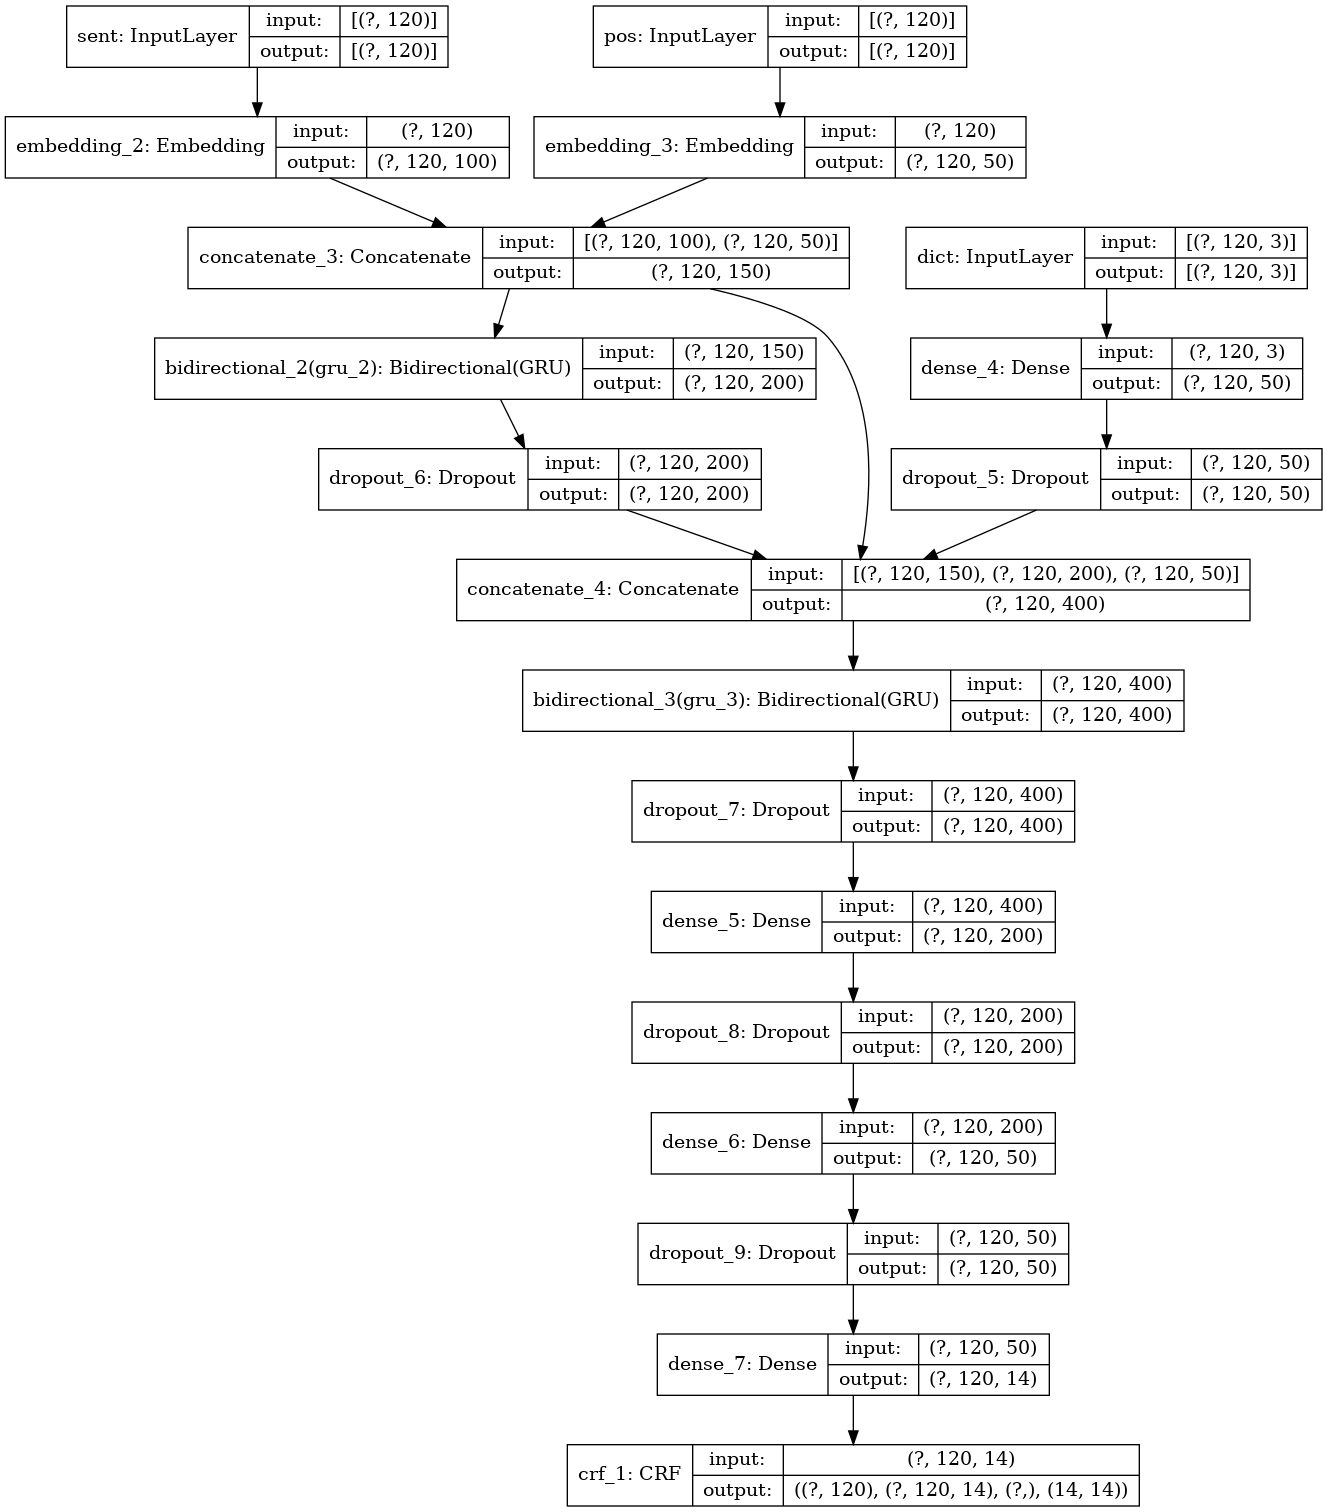

In [19]:
from keras.utils import plot_model
plot_model(base_model, "2GRU+POS.png", show_shapes=True)